# One-Hot Encoding

원-핫 인코딩은 선택해야 하는 선택지의 개수만큼의 차원을 가지면서, 각 선택지의 인덱스에 해당하는 원소에는 1, 나머지 원소는 0의 값을 가지도록 하는 표현 방법입니다.

다중 클래스 분류 문제가 각 클래스 간의 관계가 균등하다는 점에서 원-핫 벡터는 이러한 점을 표현할 수 있는 적절한 표현 방법

만약 클래스 표기를 1,2,3,4 식으로 한다면 수의 크기에 따라 가중치가 부여될 수 있음. ex) loss function을 통한 계산

# Softmax Regression's cost function

In [1]:
import torch
import torch.nn.functional as F

In [2]:
z = torch.FloatTensor([1, 2, 3])

In [3]:
hypothesis = F.softmax(z, dim=0)

In [4]:
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [5]:
hypothesis.sum()

tensor(1.)

In [6]:
# random matrix
z = torch.rand(3,5, requires_grad=True)

In [7]:
hypothesis = F.softmax(z, dim=1)

In [8]:
z

tensor([[0.3029, 0.4437, 0.3436, 0.8640, 0.5296],
        [0.3061, 0.6031, 0.9009, 0.9213, 0.8244],
        [0.2185, 0.3983, 0.9097, 0.1714, 0.0017]], requires_grad=True)

In [9]:
print(hypothesis)

tensor([[0.1613, 0.1857, 0.1680, 0.2827, 0.2023],
        [0.1301, 0.1751, 0.2358, 0.2406, 0.2184],
        [0.1680, 0.2011, 0.3354, 0.1603, 0.1353]], grad_fn=<SoftmaxBackward0>)


In [10]:
y = torch.randint(5,(3,)).long()
print(y)


tensor([2, 3, 4])


In [11]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

$cost(W) = \frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{k}y_{j}^{(i)}\ × (-log(p_{j}^{(i)}))$

In [12]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

In [13]:
print(cost)

tensor(1.7363, grad_fn=<MeanBackward0>)


F.softmax() + torch.log() = F.log_softmax()

In [14]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.8245, -1.6837, -1.7838, -1.2634, -1.5978],
        [-2.0396, -1.7426, -1.4448, -1.4244, -1.5213],
        [-1.7837, -1.6040, -1.0926, -1.8309, -2.0006]], grad_fn=<LogBackward0>)

In [15]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.8245, -1.6837, -1.7838, -1.2634, -1.5978],
        [-2.0396, -1.7426, -1.4448, -1.4244, -1.5213],
        [-1.7837, -1.6040, -1.0926, -1.8309, -2.0006]],
       grad_fn=<LogSoftmaxBackward0>)

F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [16]:
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.7363, grad_fn=<MeanBackward0>)

In [17]:
# 두번째 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.7363, grad_fn=<MeanBackward0>)

In [18]:
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y) # nll이란 Negative Log Likelihood의 약자

tensor(1.7363, grad_fn=<NllLossBackward0>)

In [19]:
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.7363, grad_fn=<NllLossBackward0>)

F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않습니다.

# Softmax Regression Implementation

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(1)

In [21]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [22]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [24]:
y_one_hot #y_train에서 원-핫 인코딩을 한 결과이어야 합니다. 클래스의 개수는 3개이므로 y_train에 원-핫 인코딩한 결과는 8 × 3의 개수를 가져야 합니다.

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [25]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

In [29]:
nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/5000 Cost: 0.114068
Epoch  100/5000 Cost: 0.112499
Epoch  200/5000 Cost: 0.110970
Epoch  300/5000 Cost: 0.109480
Epoch  400/5000 Cost: 0.108028
Epoch  500/5000 Cost: 0.106612
Epoch  600/5000 Cost: 0.105230
Epoch  700/5000 Cost: 0.103883
Epoch  800/5000 Cost: 0.102568
Epoch  900/5000 Cost: 0.101284
Epoch 1000/5000 Cost: 0.100031
Epoch 1100/5000 Cost: 0.098806
Epoch 1200/5000 Cost: 0.097611
Epoch 1300/5000 Cost: 0.096442
Epoch 1400/5000 Cost: 0.095300
Epoch 1500/5000 Cost: 0.094183
Epoch 1600/5000 Cost: 0.093092
Epoch 1700/5000 Cost: 0.092024
Epoch 1800/5000 Cost: 0.090979
Epoch 1900/5000 Cost: 0.089957
Epoch 2000/5000 Cost: 0.088957
Epoch 2100/5000 Cost: 0.087978
Epoch 2200/5000 Cost: 0.087019
Epoch 2300/5000 Cost: 0.086080
Epoch 2400/5000 Cost: 0.085161
Epoch 2500/5000 Cost: 0.084260
Epoch 2600/5000 Cost: 0.083377
Epoch 2700/5000 Cost: 0.082512
Epoch 2800/5000 Cost: 0.081664
Epoch 2900/5000 Cost: 0.080833
Epoch 3000/5000 Cost: 0.080018
Epoch 3100/5000 Cost: 0.079218
Epoch 32

# 다시 구현

In [31]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/5000 Cost: 1.098612
Epoch  100/5000 Cost: 0.704199
Epoch  200/5000 Cost: 0.623000
Epoch  300/5000 Cost: 0.565717
Epoch  400/5000 Cost: 0.515291
Epoch  500/5000 Cost: 0.467662
Epoch  600/5000 Cost: 0.421278
Epoch  700/5000 Cost: 0.375402
Epoch  800/5000 Cost: 0.329766
Epoch  900/5000 Cost: 0.285073
Epoch 1000/5000 Cost: 0.248155
Epoch 1100/5000 Cost: 0.232676
Epoch 1200/5000 Cost: 0.221399
Epoch 1300/5000 Cost: 0.211129
Epoch 1400/5000 Cost: 0.201736
Epoch 1500/5000 Cost: 0.193113
Epoch 1600/5000 Cost: 0.185170
Epoch 1700/5000 Cost: 0.177829
Epoch 1800/5000 Cost: 0.171027
Epoch 1900/5000 Cost: 0.164707
Epoch 2000/5000 Cost: 0.158821
Epoch 2100/5000 Cost: 0.153327
Epoch 2200/5000 Cost: 0.148186
Epoch 2300/5000 Cost: 0.143368
Epoch 2400/5000 Cost: 0.138843
Epoch 2500/5000 Cost: 0.134586
Epoch 2600/5000 Cost: 0.130574
Epoch 2700/5000 Cost: 0.126786
Epoch 2800/5000 Cost: 0.123206
Epoch 2900/5000 Cost: 0.119817
Epoch 3000/5000 Cost: 0.116604
Epoch 3100/5000 Cost: 0.113554
Epoch 32

# Softmax Linear Regression to nn.Module

In [32]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/5000 Cost: 1.616785
Epoch  100/5000 Cost: 0.658891
Epoch  200/5000 Cost: 0.573443
Epoch  300/5000 Cost: 0.518151
Epoch  400/5000 Cost: 0.473265
Epoch  500/5000 Cost: 0.433516
Epoch  600/5000 Cost: 0.396563
Epoch  700/5000 Cost: 0.360914
Epoch  800/5000 Cost: 0.325392
Epoch  900/5000 Cost: 0.289178
Epoch 1000/5000 Cost: 0.254148
Epoch 1100/5000 Cost: 0.234973
Epoch 1200/5000 Cost: 0.223493
Epoch 1300/5000 Cost: 0.213053
Epoch 1400/5000 Cost: 0.203509
Epoch 1500/5000 Cost: 0.194751
Epoch 1600/5000 Cost: 0.186687
Epoch 1700/5000 Cost: 0.179238
Epoch 1800/5000 Cost: 0.172338
Epoch 1900/5000 Cost: 0.165930
Epoch 2000/5000 Cost: 0.159963
Epoch 2100/5000 Cost: 0.154396
Epoch 2200/5000 Cost: 0.149189
Epoch 2300/5000 Cost: 0.144311
Epoch 2400/5000 Cost: 0.139730
Epoch 2500/5000 Cost: 0.135422
Epoch 2600/5000 Cost: 0.131363
Epoch 2700/5000 Cost: 0.127533
Epoch 2800/5000 Cost: 0.123913
Epoch 2900/5000 Cost: 0.120487
Epoch 3000/5000 Cost: 0.117240
Epoch 3100/5000 Cost: 0.114159
Epoch 32

# Softmax class

In [33]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

In [34]:
model = SoftmaxClassifierModel()


optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/5000 Cost: 2.637636
Epoch  100/5000 Cost: 0.647903
Epoch  200/5000 Cost: 0.564643
Epoch  300/5000 Cost: 0.511043
Epoch  400/5000 Cost: 0.467249
Epoch  500/5000 Cost: 0.428280
Epoch  600/5000 Cost: 0.391924
Epoch  700/5000 Cost: 0.356742
Epoch  800/5000 Cost: 0.321577
Epoch  900/5000 Cost: 0.285617
Epoch 1000/5000 Cost: 0.250818
Epoch 1100/5000 Cost: 0.232102
Epoch 1200/5000 Cost: 0.220866
Epoch 1300/5000 Cost: 0.210637
Epoch 1400/5000 Cost: 0.201279
Epoch 1500/5000 Cost: 0.192685
Epoch 1600/5000 Cost: 0.184767
Epoch 1700/5000 Cost: 0.177449
Epoch 1800/5000 Cost: 0.170667
Epoch 1900/5000 Cost: 0.164366
Epoch 2000/5000 Cost: 0.158497
Epoch 2100/5000 Cost: 0.153018
Epoch 2200/5000 Cost: 0.147892
Epoch 2300/5000 Cost: 0.143087
Epoch 2400/5000 Cost: 0.138574
Epoch 2500/5000 Cost: 0.134328
Epoch 2600/5000 Cost: 0.130327
Epoch 2700/5000 Cost: 0.126550
Epoch 2800/5000 Cost: 0.122979
Epoch 2900/5000 Cost: 0.119599
Epoch 3000/5000 Cost: 0.116394
Epoch 3100/5000 Cost: 0.113352
Epoch 32

# Softmax Regression : MNIST classification

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
training_epochs = 50
batch_size = 100

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16352340.50it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 498543.88it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4525745.59it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3112322.95it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [6]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

DataLoader에는 4개의 인자가 있습니다.

첫번째 인자인 dataset은 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미합니다.

drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다.

1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다.

이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다.

이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다.

이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [7]:
linear = nn.Linear(28*28, 10, bias=True).to(device) #연산을 어디서 할지 정함

In [8]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [9]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933438
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422765
Epoch: 0016 cost = 0.272883654
Epoch: 0017 cost = 0.271629602
Epoch: 0018 cost = 0.270609826
Epoch: 0019 cost = 0.269295007
Epoch: 0020 cost = 0.268277347
Epoch: 0021 cost = 0.267255455
Epoch: 0022 cost = 0.266613454
Epoch: 0023 cost = 0.265661418
Epoch: 0024 cost = 0.264922321
Epoch: 0025 cost = 0.263888687
Epoch: 0026 cost = 0.263269812
Epoch: 0027 cost = 0.262586147
Epoch: 0028 cost = 0.261751652
Epoch: 0029 cost = 0.261135817
Epoch: 0030 cost = 0.260536909
Epoch: 0031 cost = 0.260275453
Epoch: 0032 cost = 0.259709179
Epoch: 0

training_epochs의 값은 50로 설정되어 있으며, 모델은 총 50번의 에포크 동안 학습됩니다.

avg_cost는 에포크 동안의 평균 비용을 저장하는 변수이며, total_batch는 에포크당 수행할 배치(batch) 수를 계산합니다.

data_loader는 미니 배치 학습을 위해 데이터를 반복적으로 제공하는 역할을 합니다.

루프 내부에서는 각 배치마다 입력 데이터 X와 레이블 Y를 받아옵니다.

이때, X는 이미지 데이터로서 (100, 784) 크기의 텐서로 변환되는데, 이는 배치 크기 100에 28x28 픽셀의 이미지가 일렬로 펼쳐진 상태를 나타냅니다.

이 데이터와 레이블 Y는 모델 학습을 위해 지정된 장치(device)로 전송됩니다.

다음으로, 옵티마이저의 기울기 정보를 초기화하고, 모델의 가설(hypothesis)을 계산합니다.

linear(X)는 모델의 순전파(forward) 과정을 수행하여 예측 값을 계산합니다.

그 후, 손실 함수(criterion)를 사용하여 예측 값과 실제 레이블 Y 간의 비용(cost)을 계산합니다.

이 비용은 모델의 성능을 나타내며, 비용이 작을수록 모델의 예측이 실제 값에 가까워집니다.

이후, cost.backward()를 호출하여 역전파(backpropagation)를 수행하고, 기울기를 계산합니다.

그리고 옵티마이저의 step()을 호출하여 모델의 파라미터(가중치와 편향)를 업데이트합니다.

각 배치의 비용을 avg_cost에 누적하여 에포크당 평균 비용을 계산하고, 에포크가 끝날 때마다 현재 에포크 번호와 평균 비용을 출력합니다.

모든 에포크가 종료되면 "Learning finished" 메시지를 출력하여 학습이 완료되었음을 알립니다.

Accuracy: 0.8729999661445618
Label:  2
Prediction:  2


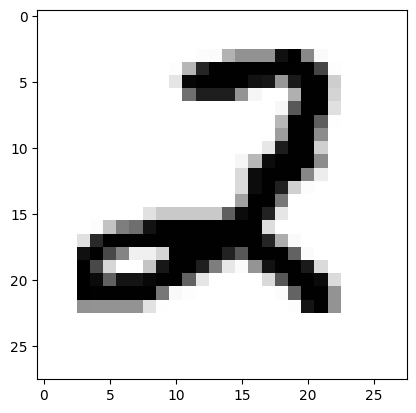

In [20]:
with torch.no_grad():
  x_test = mnist_test.test_data.view(-1, 28*28).float().to(device)
  y_test = mnist_test.test_labels.to(device)

  pred = linear(x_test)
  correct_prediction = torch.argmax(pred, 1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

  r = random.randint(0, len(mnist_test) - 1)
  X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
  Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

  print('Label: ', Y_single_data.item())
  single_prediction = linear(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()